## Note au jury — cahier d'expériences RL pour la couverture delta

Ce notebook expose la démarche technique utilisée pour entraîner une politique de couverture dans un cadre RL. Les cellules de code restent inchangées ; seules les notes sont clarifiées pour expliciter les choix méthodologiques et les hypothèses de marché.


# Reinforcement Learning for Finance — Chapitre 07 : Couverture dynamique

Ce document détaille la mise en place d'un agent RL pour ajuster la couverture d'un call européen. L'agent observe l'état du marché simulé (prix, temps, greeks) et apprend une stratégie de delta-hedging sous contrainte de coûts de transaction. Les étapes clés sont : formulation MDP, génération de trajectoires, politique réseau (Deep Q-Learning), et évaluation hors-échantillon.


## Rappel sur la couverture delta

La couverture delta consiste à neutraliser la sensibilité du portefeuille aux variations instantanées du sous-jacent. Ici, la politique RL cherche à approximer un ajustement continu dans un contexte discret : 
- minimiser le coût cumulé (PNL de couverture + pénalités de transaction),
- gérer l'impact de la volatilité et du temps restant à maturité,
- rester robuste aux erreurs de modélisation (sigma implicite vs réalisée).


In [1]:
import math
import random
import numpy as np
import pandas as pd
from scipy import stats
from pylab import plt, mpl

In [2]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)

In [3]:
from bsm73 import bsm_call_value

In [4]:
S0 = 100
K = 100
T = 1.
t = 0.
r = 0.05
sigma = 0.2

In [5]:
bsm_call_value(S0, K, T, t, r, sigma)

10.450583572185565

In [6]:
random.seed(1000)

In [7]:
def simulate_gbm(S0, T, r, sigma, steps=100):
    gbm = [S0]
    dt = T / steps
    for t in range(1, steps + 1):
        st = gbm[-1] * math.exp((r - sigma ** 2 / 2) * dt
                    + sigma * math.sqrt(dt) * random.gauss(0, 1))
        gbm.append(st)
    return gbm

In [8]:
gbm = simulate_gbm(S0, T, r, sigma)

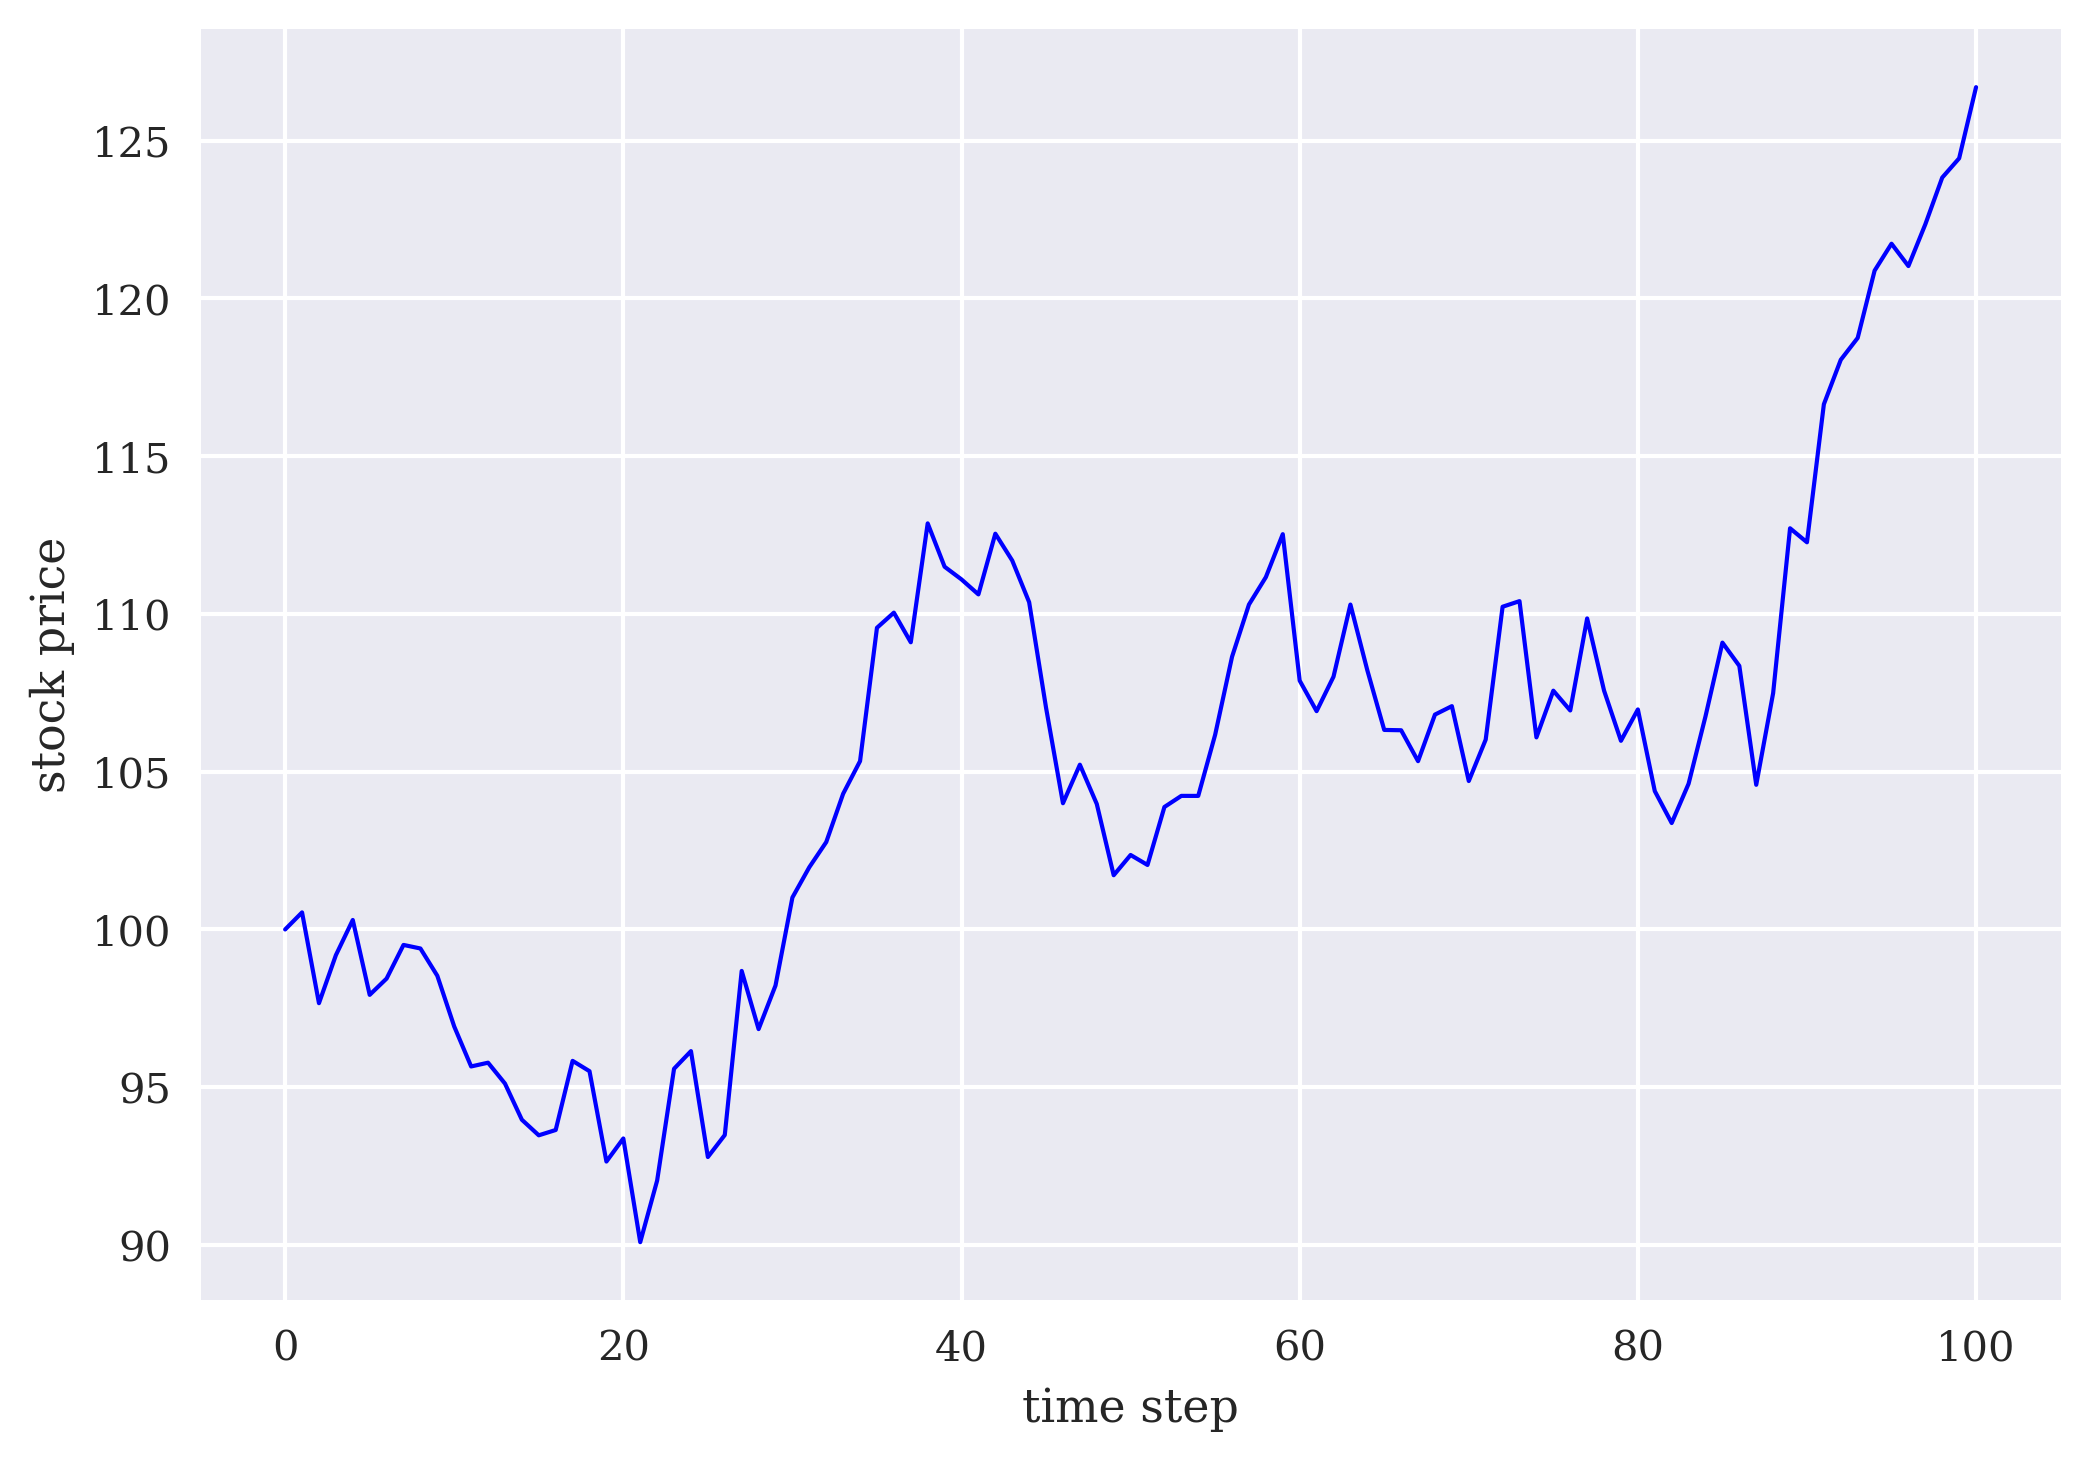

In [9]:
plt.plot(gbm, lw=1.0, c='b')
plt.xlabel('time step')
plt.ylabel('stock price');

In [10]:
def bsm_delta(St, K, T, t, r, sigma):
    d1 = ((math.log(St / K) + (r + 0.5 * sigma ** 2) * (T - t)) /
          (sigma * math.sqrt(T - t)))
    return stats.norm.cdf(d1, 0, 1)

In [11]:
S_ = range(40, 181, 4)

In [12]:
d = [bsm_delta(s, K, T, 0, r, sigma) for s in S_]

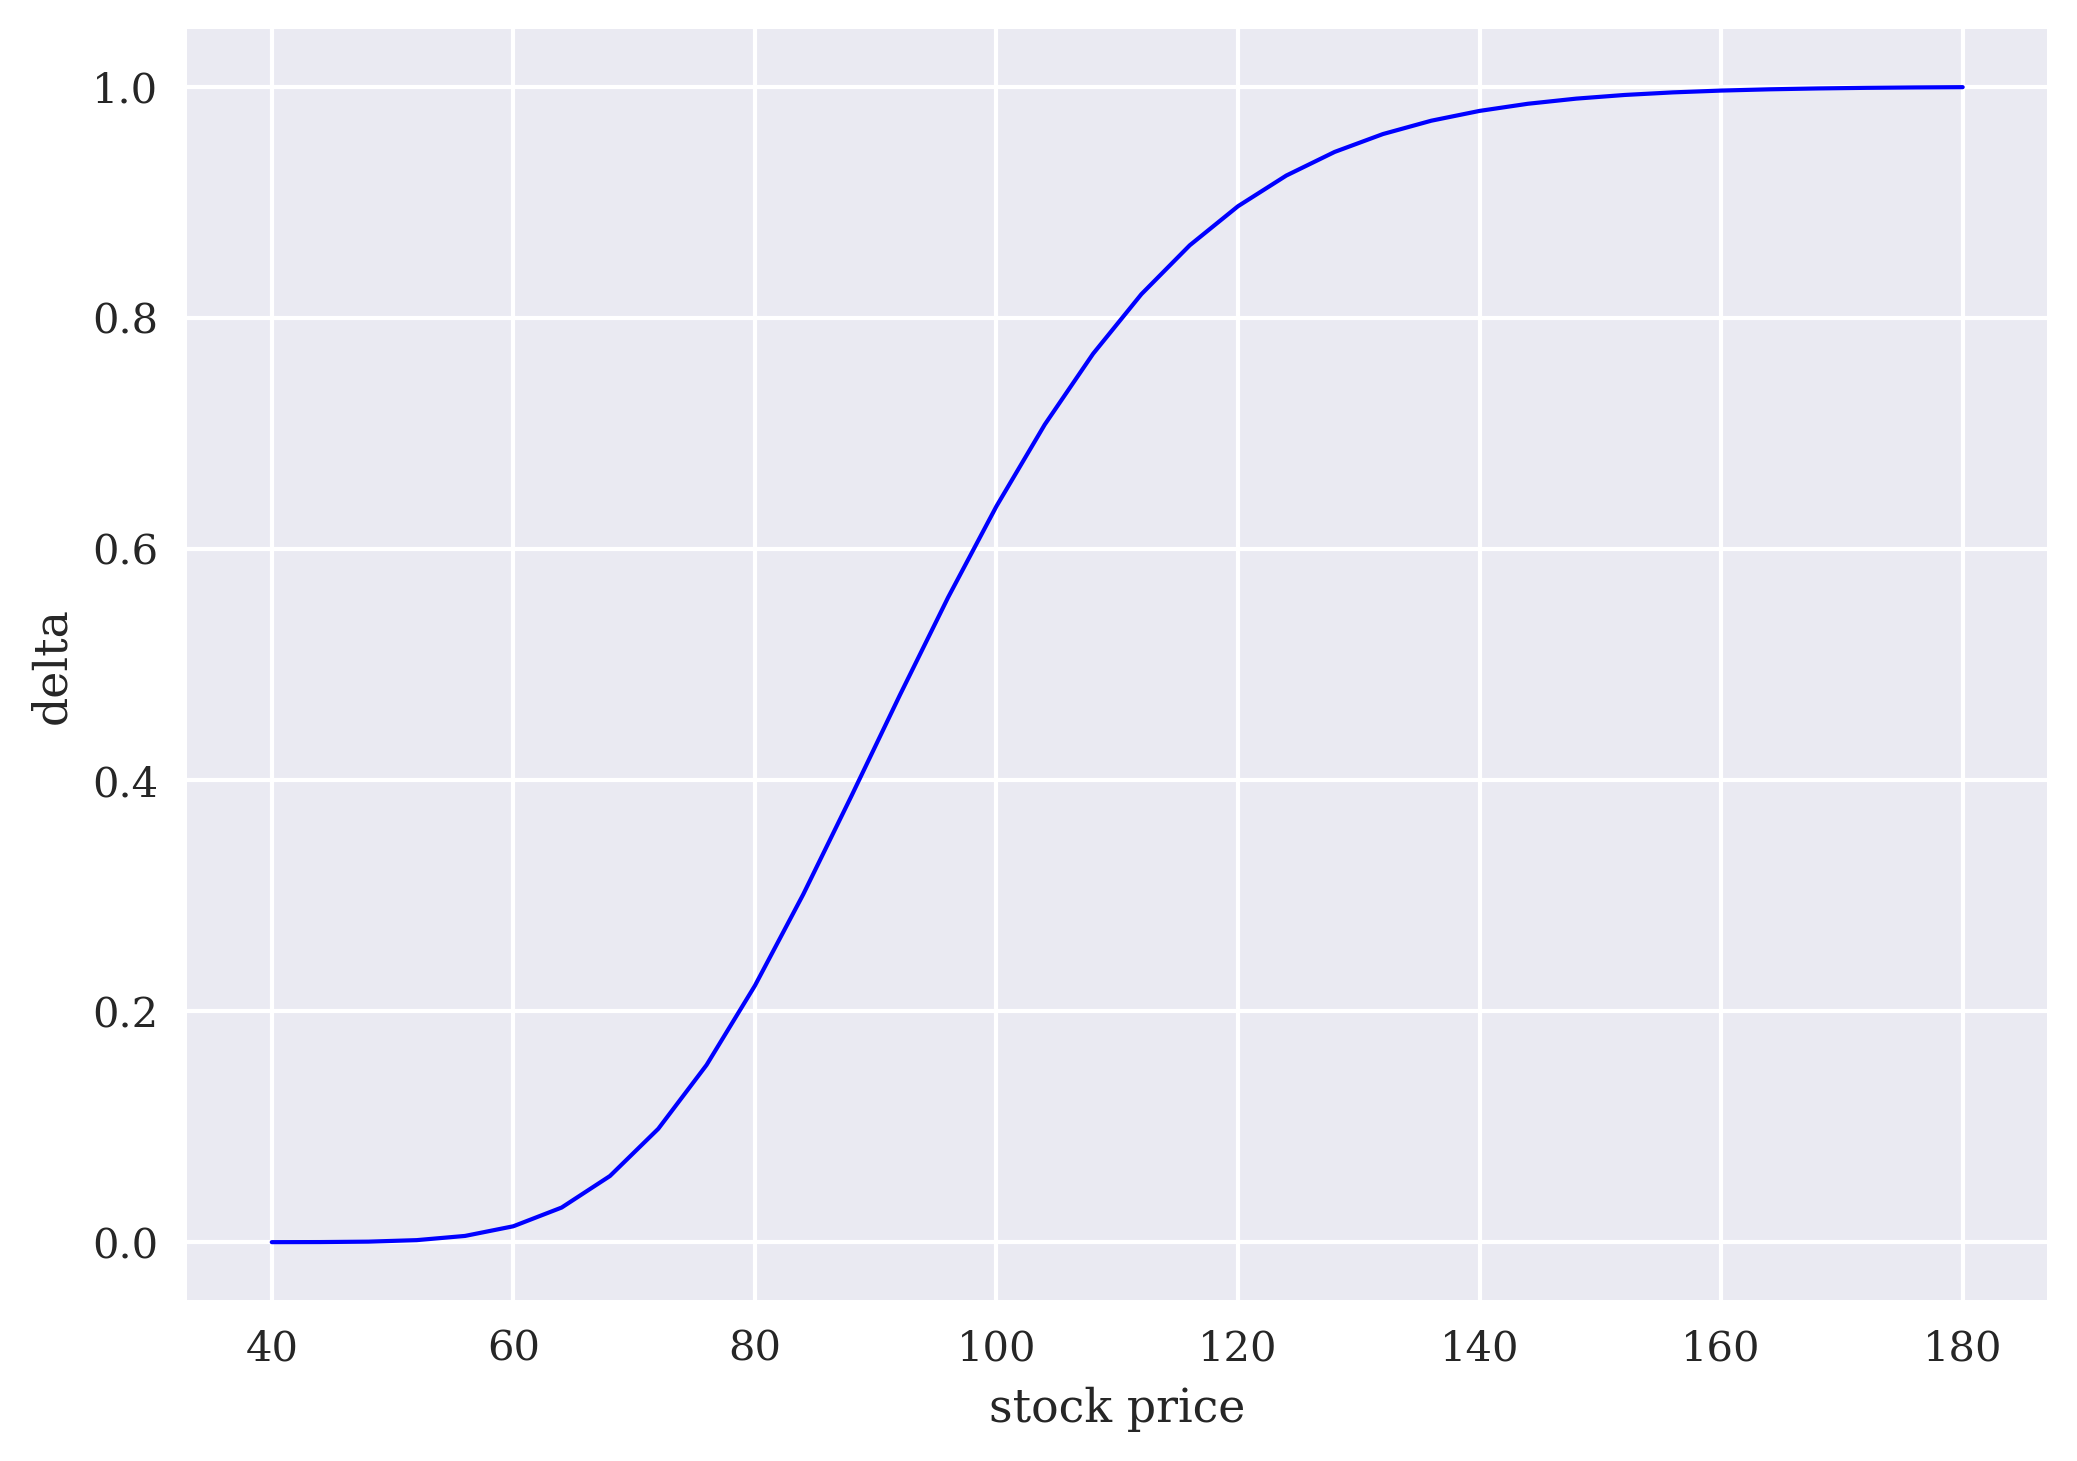

In [13]:
plt.plot(S_, d, lw=1.0, c='b')
plt.xlabel('stock price')
plt.ylabel('delta');

In [14]:
dt = T / (len(gbm) - 1)

In [15]:
bond = [math.exp(r * i * dt) for i in range(len(gbm))]

In [16]:
def option_replication():
    res = pd.DataFrame()
    for i in range(len(gbm) - 1):
        C = bsm_call_value(gbm[i], K, T, i * dt, r, sigma)
        if i == 0:
            s = bsm_delta(gbm[i], K, T, i * dt, r, sigma)
            b = (C - s * gbm[i]) / bond[i]
        else:
            V = s * gbm[i] + b * bond[i]
            s = bsm_delta(gbm[i], K, T, i * dt, r, sigma)
            b = (C - s * gbm[i]) / bond[i]
            df = pd.DataFrame({'St': gbm[i], 'C': C, 'V': V,
                               's': s, 'b': b}, index=[0])
            res = pd.concat((res, df), ignore_index=True)
    return res

In [17]:
res = option_replication()

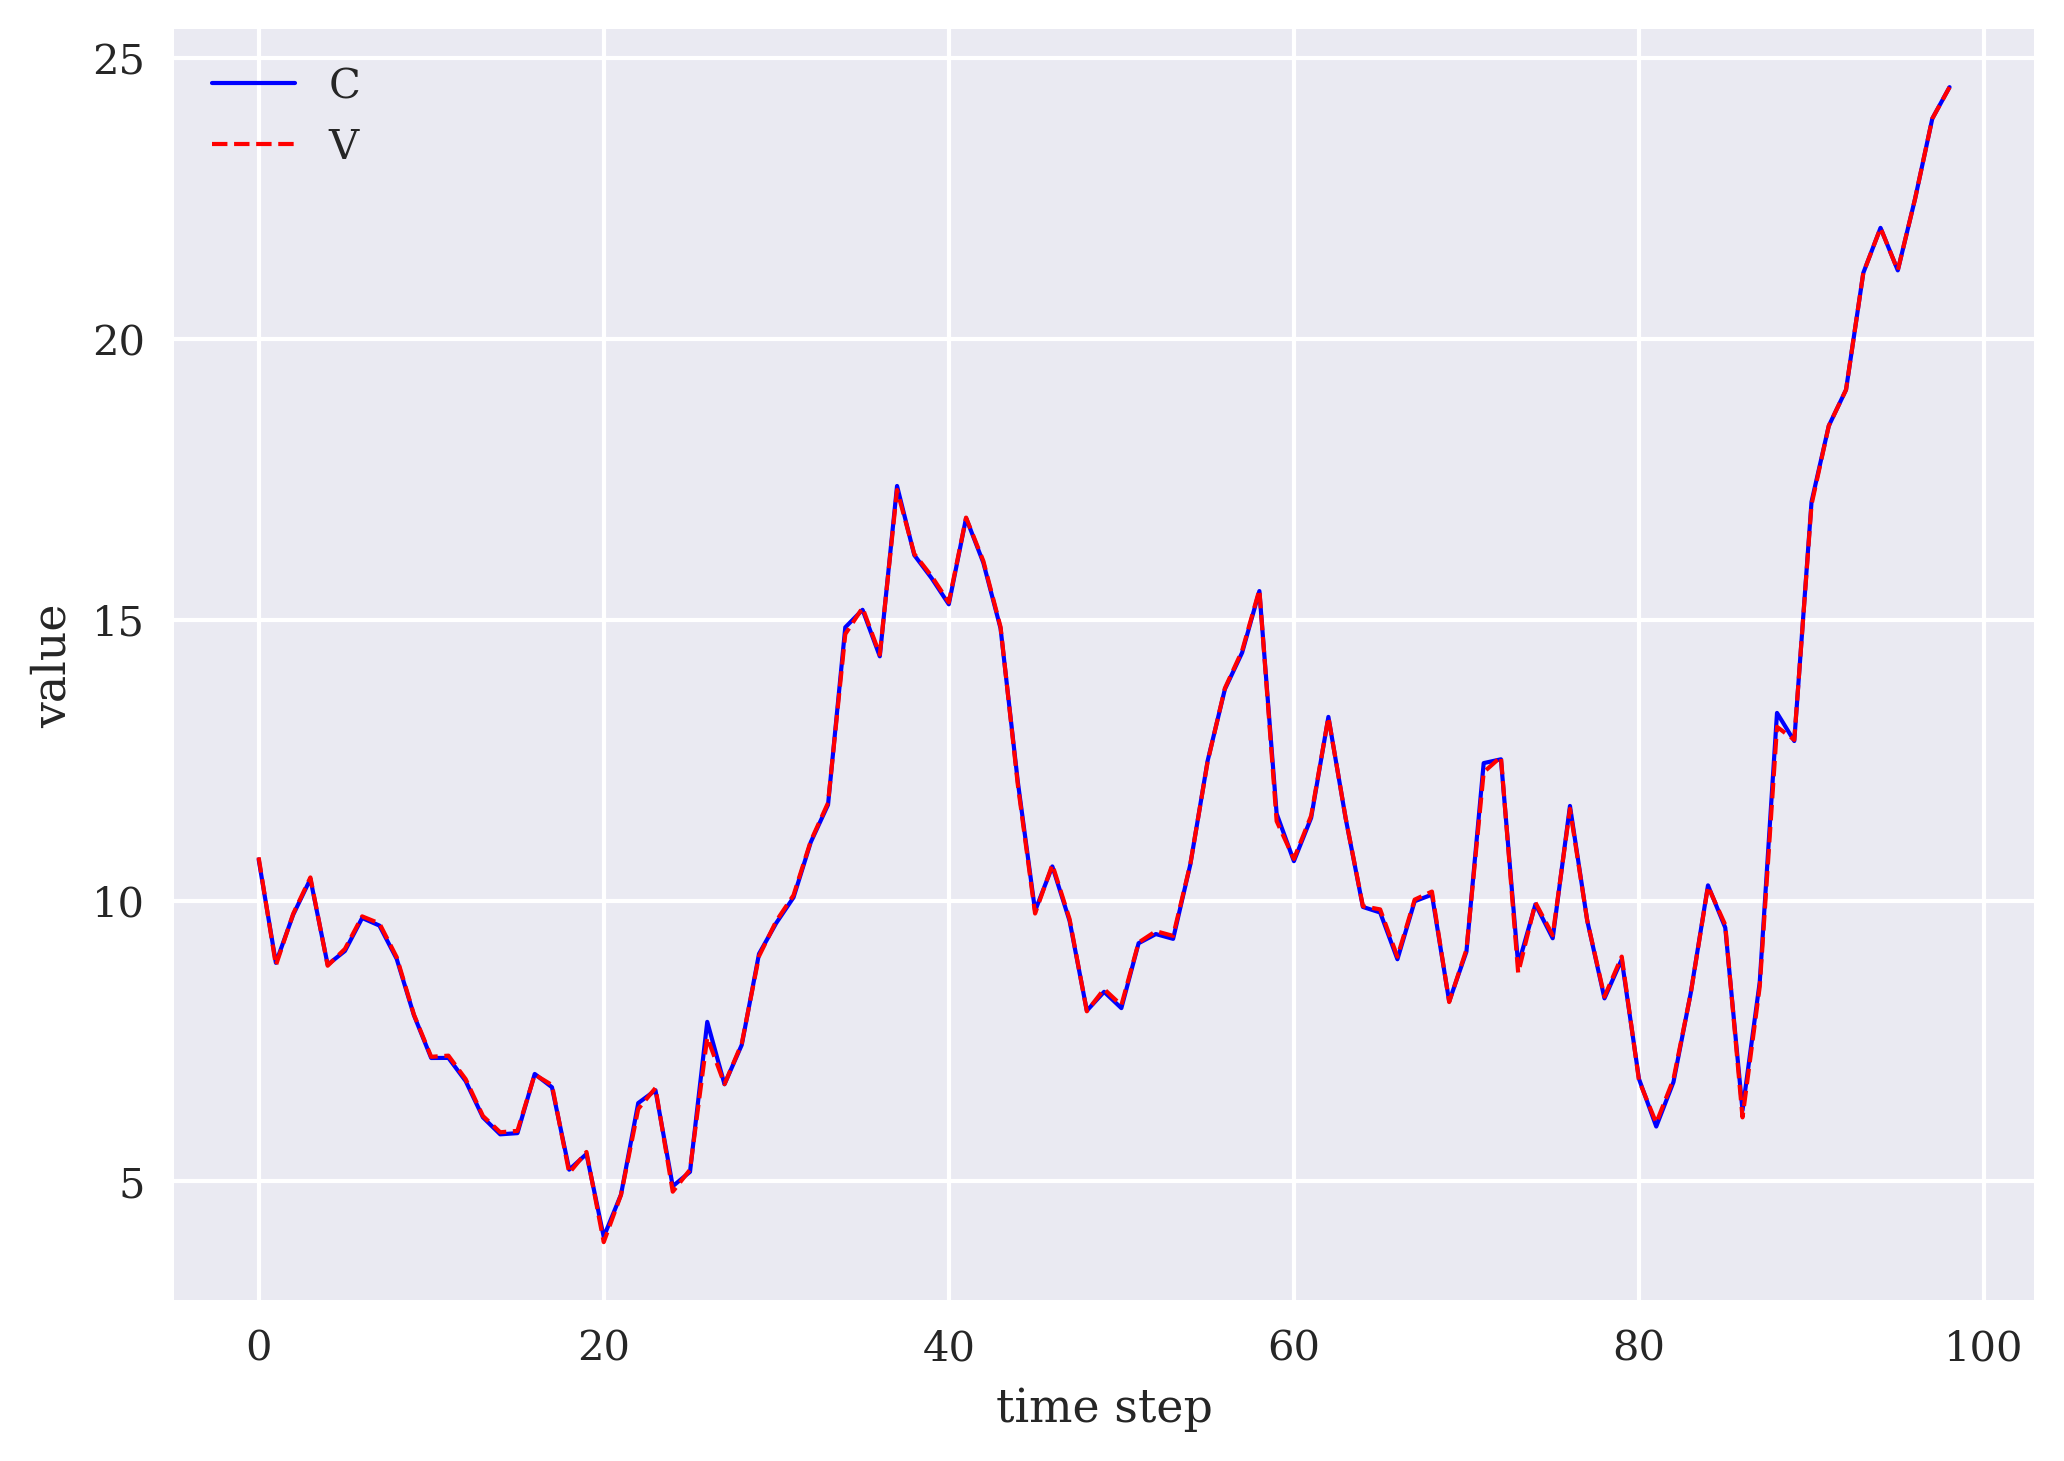

In [18]:
res[['C', 'V']].plot(style=['b', 'r--'], lw=1)
plt.xlabel('time step')
plt.ylabel('value');

In [19]:
(res['V'] - res['C']).mean()

-0.0009828178536539433

In [20]:
((res['V'] - res['C']) ** 2).mean()

0.0037550154602652027

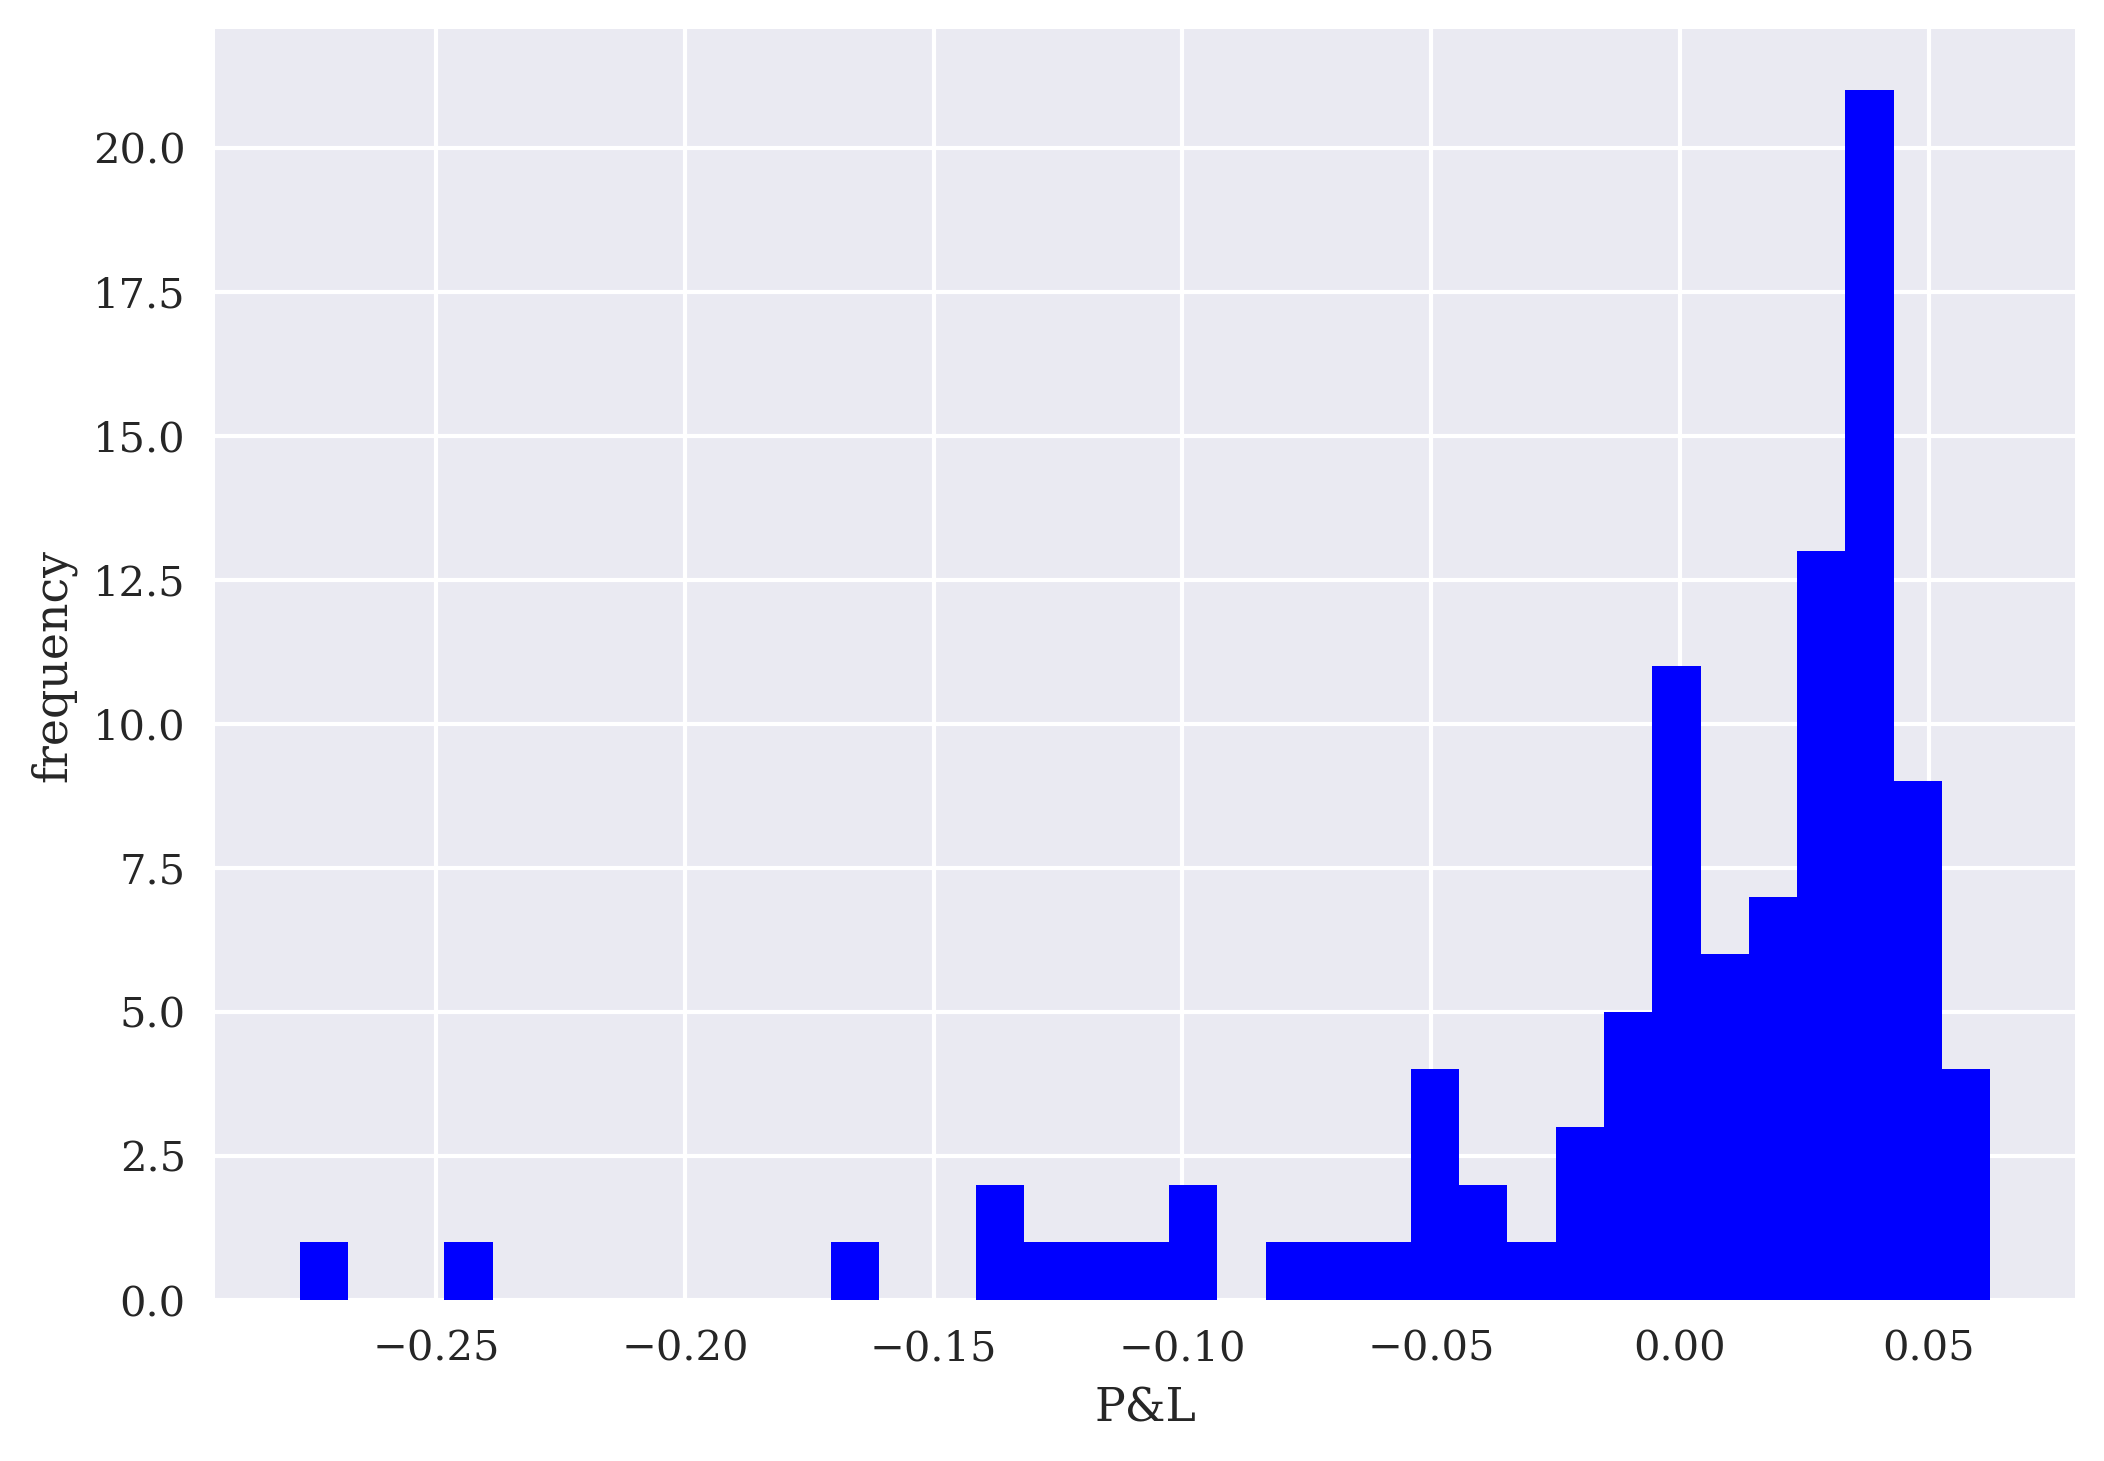

In [21]:
(res['V'] - res['C']).hist(bins=35, color='b')
plt.xlabel('P&L')
plt.ylabel('frequency');

## Environnement de simulation pour l'apprentissage

L'environnement génère des trajectoires de prix (GBM) et retourne à chaque pas : état (prix, temps, position), action (ajuster la couverture), récompense (PNL incrémental net de coûts). Les hyperparamètres à surveiller : horizon (T, steps), variance du sous-jacent, niveau de coûts de transaction, et taille du réseau DQN.


In [22]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [23]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        random.seed(seed)
    def sample(self):
        return random.random()

In [24]:
class Hedging:
    def __init__(self, S0, K_, T, r_, sigma_, steps):
        self.initial_value = S0
        self.strike_ = K_
        self.maturity = T
        self.short_rate_ = r_
        self.volatility_ = sigma_
        self.steps = steps
        self.observation_space = observation_space(5)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(1)
        self._simulate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0

In [25]:
class Hedging(Hedging):
    def _simulate_data(self):
        s = [self.initial_value]
        self.strike = random.choice(self.strike_)
        self.short_rate = random.choice(self.short_rate_)
        self.volatility = random.choice(self.volatility_)
        self.dt = self.maturity / self.steps
        for t in range(1, self.steps + 1):
            st = s[t - 1] * math.exp(
              ((self.short_rate - self.volatility ** 2 / 2) * self.dt +
                self.volatility * math.sqrt(self.dt) *
                  random.gauss(0, 1)))
            s.append(st)
        self.data = pd.DataFrame(s, columns=['index'])
        self.data['bond'] = np.exp(self.short_rate *
                            np.arange(len(self.data)) * self.dt)

In [26]:
class Hedging(Hedging):
    def _get_state(self):
        St = self.data['index'].iloc[self.bar]
        Bt = self.data['bond'].iloc[self.bar]
        ttm = self.maturity - self.bar * self.dt
        if ttm > 0:
            Ct = bsm_call_value(St, self.strike,
                           self.maturity, self.bar * self.dt,
                           self.short_rate, self.volatility)
        else:
            Ct = max(St - self.strike, 0)
        return np.array([St, Bt, ttm, Ct, self.strike, self.short_rate,
                         self.stock, self.bond]), {} 
    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)
    def reset(self):
        self.bar = 0
        self.bond = 0
        self.stock = 0
        self.treward = 0
        self.episode += 1
        self._simulate_data()
        self.state, _ = self._get_state()
        return self.state, _

In [27]:
class Hedging(Hedging):
    def step(self, action):
        if self.bar == 0:
            reward = 0
            self.bar += 1
            self.stock = float(action)
            self.bond = ((self.state[3] - self.stock * self.state[0]) /
                         self.state[1])
            self.new_state, _ = self._get_state()
        else:
            self.bar += 1
            self.new_state, _ = self._get_state()
            phi_value = (self.stock * self.new_state[0] +
                   self.bond * self.new_state[1])
            pl = phi_value - self.new_state[3]
            df = pd.DataFrame({'e': self.episode, 's': self.stock,
                               'b': self.bond, 'phi': phi_value,
                               'C': self.new_state[3], 'p&l[$]': pl,
                               'p&l[%]': pl / max(self.new_state[3],
                                                  1e-4) * 100,
                               'St': self.new_state[0],
                               'Bt': self.new_state[1],
                               'K': self.strike, 'r': self.short_rate,
                               'sigma': self.volatility},
                              index=[0])
            self.portfolios = pd.concat((self.portfolios, df),
                                        ignore_index=True)
            reward = -(phi_value - self.new_state[3]) ** 2
            self.stock = float(action)
            self.bond = ((self.new_state[3] -
                          self.stock * self.new_state[0]) /
                          self.new_state[1])
        if self.bar == len(self.data) - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, float(reward), done, False, {}

In [28]:
S0 = 100.

In [29]:
hedging = Hedging(S0=S0,
              K_=np.array([0.9, 0.95, 1., 1.05, 1.10]) * S0,
              T=1.0, r_=[0, 0.01, 0.05],
              sigma_=[0.1, 0.15, 0.2], steps=2 * 252) 

In [30]:
hedging.seed(750)

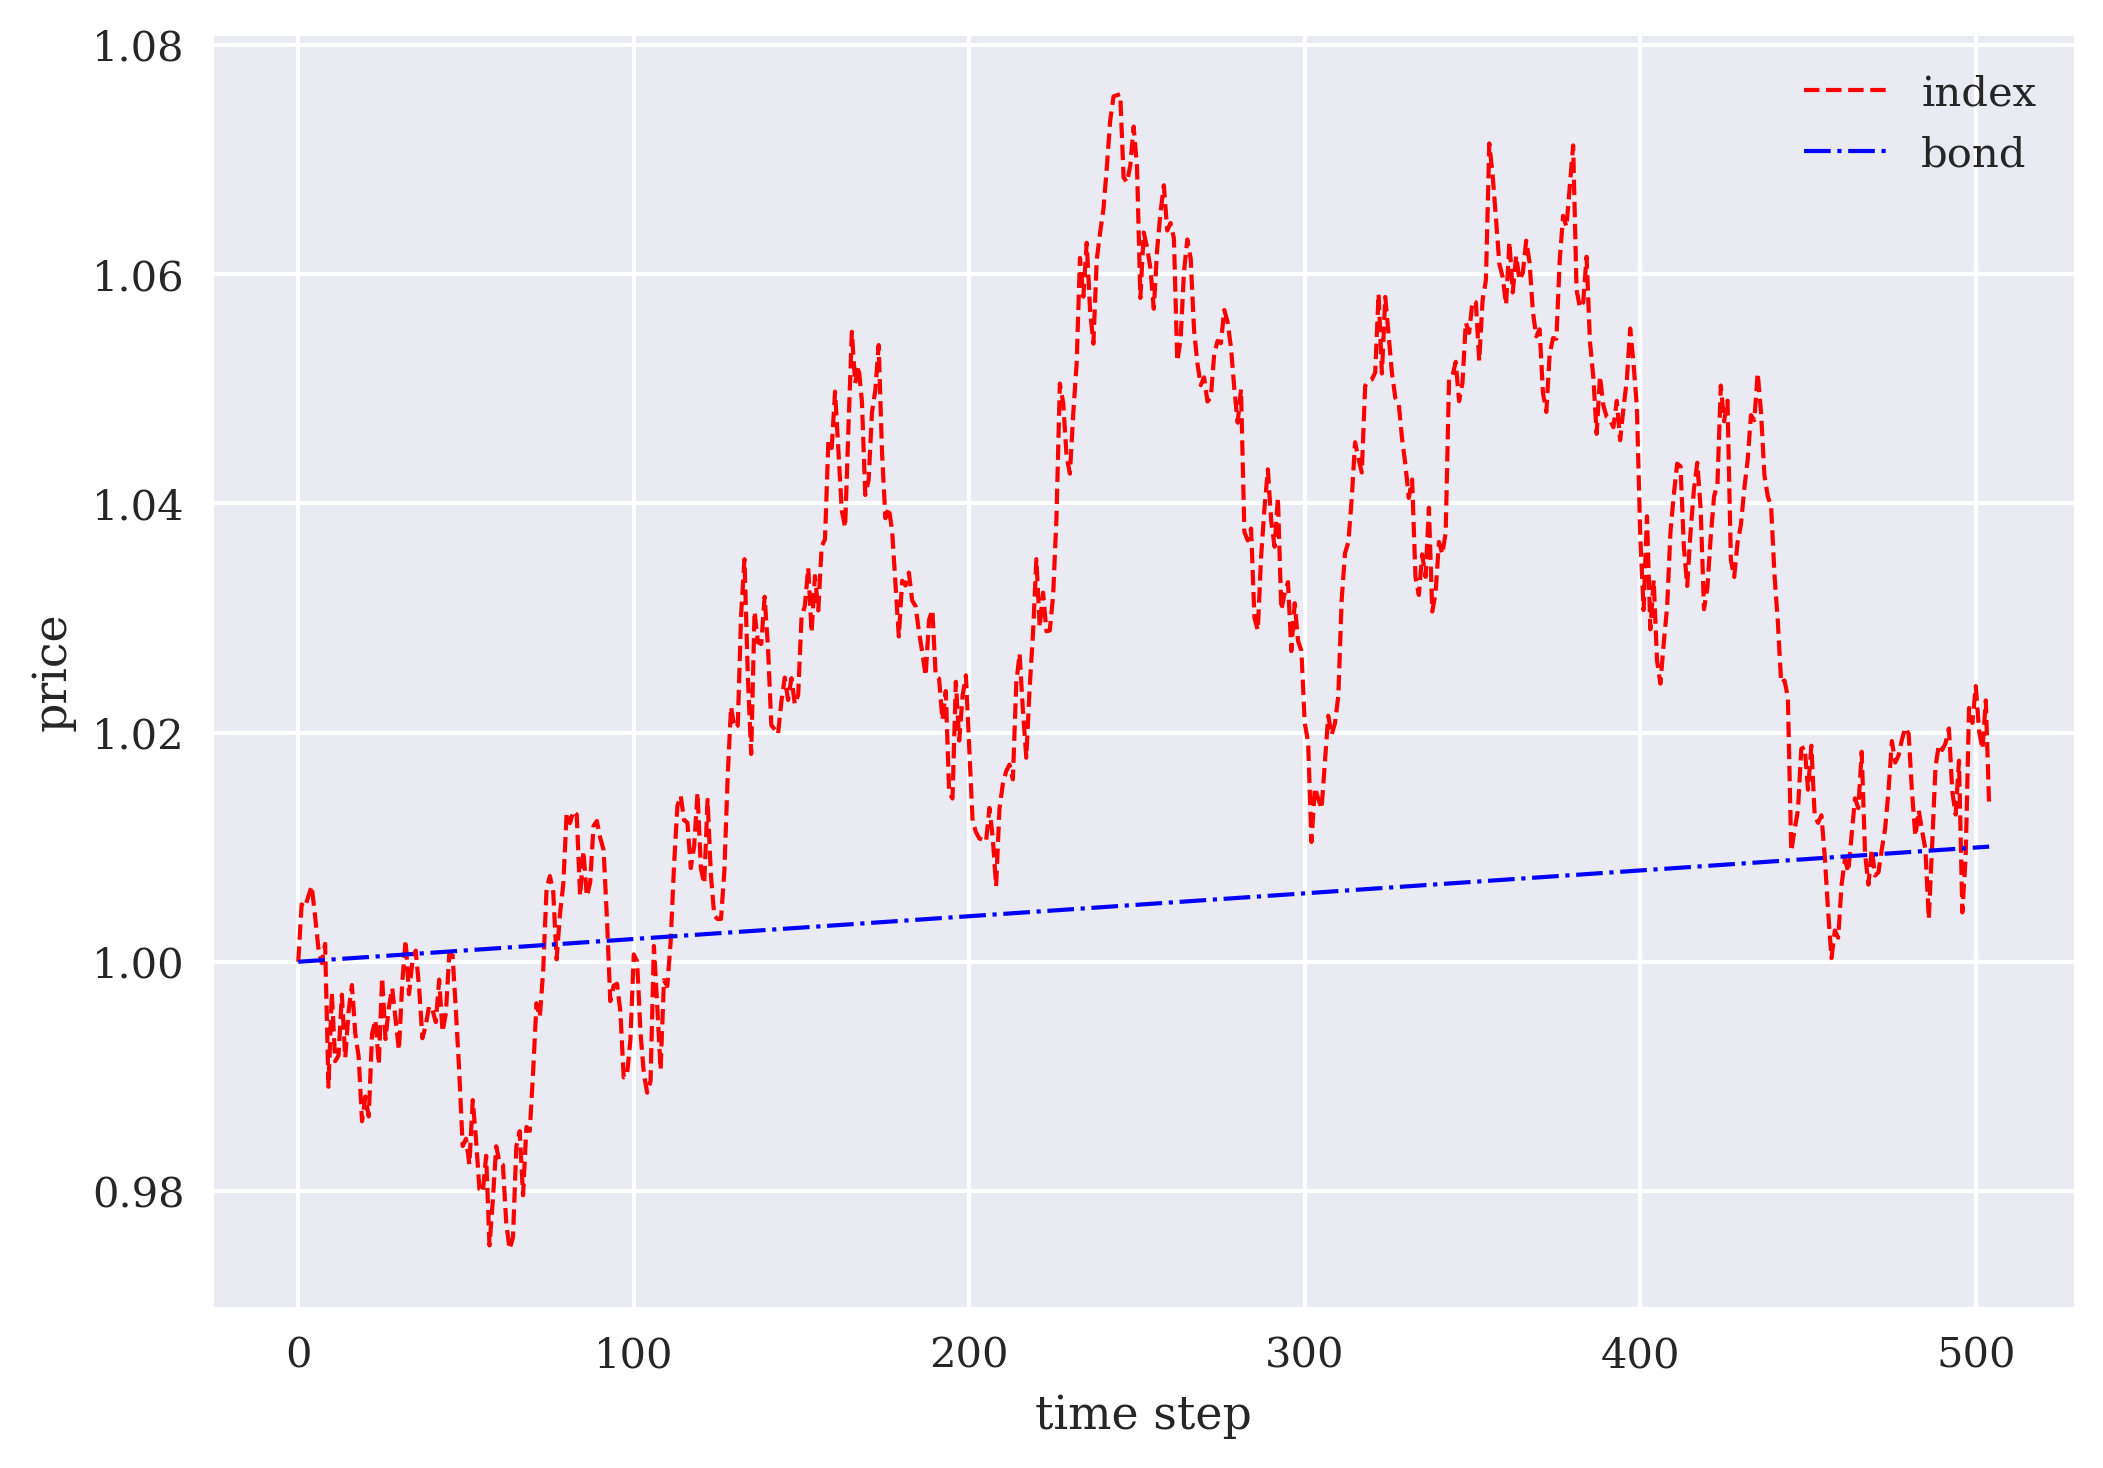

In [31]:
hedging._simulate_data()
(hedging.data / hedging.data.iloc[0]).plot(
    lw=1.0, style=['r--', 'b-.'])
plt.xlabel('time step')
plt.ylabel('price');

In [32]:
hedging.reset()
for _ in range(hedging.steps - 1):
    hedging.step(hedging.action_space.sample())

In [33]:
hedging.portfolios.head().round(4)

,e,s,b,phi,C,p&l[$],p&l[%],St,Bt,K,r,sigma
0,1,0.2678,-22.4876,3.8871,3.7649,0.1222,3.2447,98.4880,1.0,110.0,0,0.2
1,1,0.5623,-51.6103,4.7116,4.3306,0.3809,8.7957,100.1716,1.0,110.0,0,0.2
2,1,0.5996,-55.7307,4.3350,4.3258,0.0092,0.2131,100.1789,1.0,110.0,0,0.2
3,1,0.8360,-79.4251,4.7708,4.5103,0.2605,5.7760,100.7111,1.0,110.0,0,0.2
4,1,0.0274,1.7478,4.5084,4.4776,0.0308,0.6877,100.6422,1.0,110.0,0,0.2


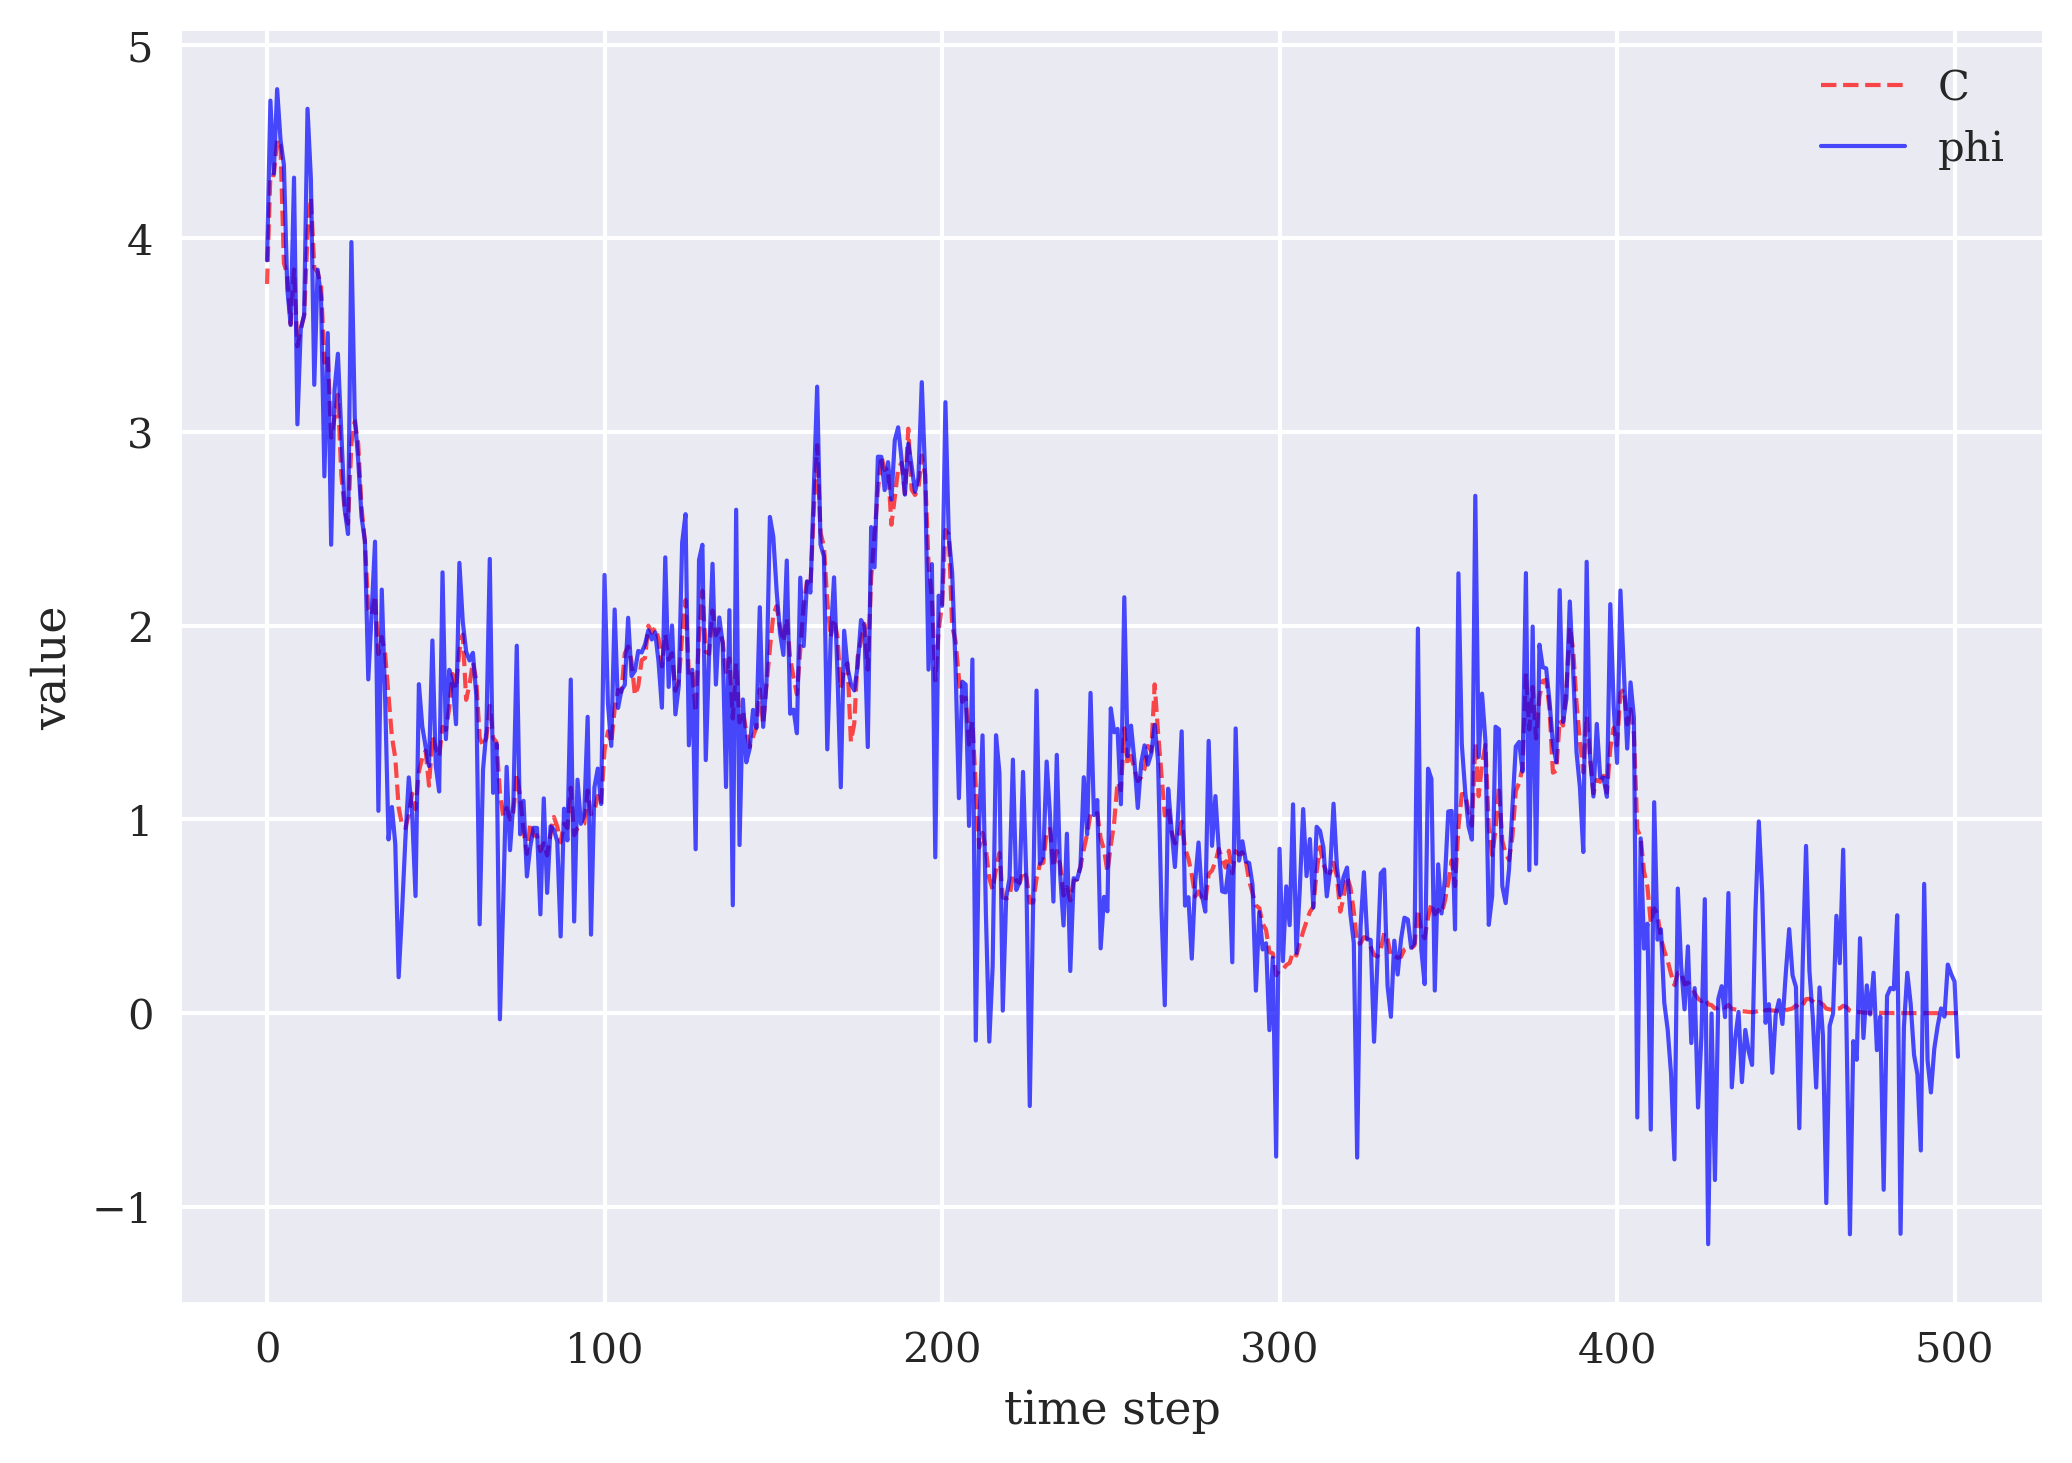

In [34]:
hedging.portfolios[['C', 'phi']].plot(
    style=['r--', 'b-'], lw=1, alpha=0.7)
plt.xlabel('time step')
plt.ylabel('value');

In [35]:
hedging.portfolios['p&l[$]'].apply(abs).sum()

133.4348359335146

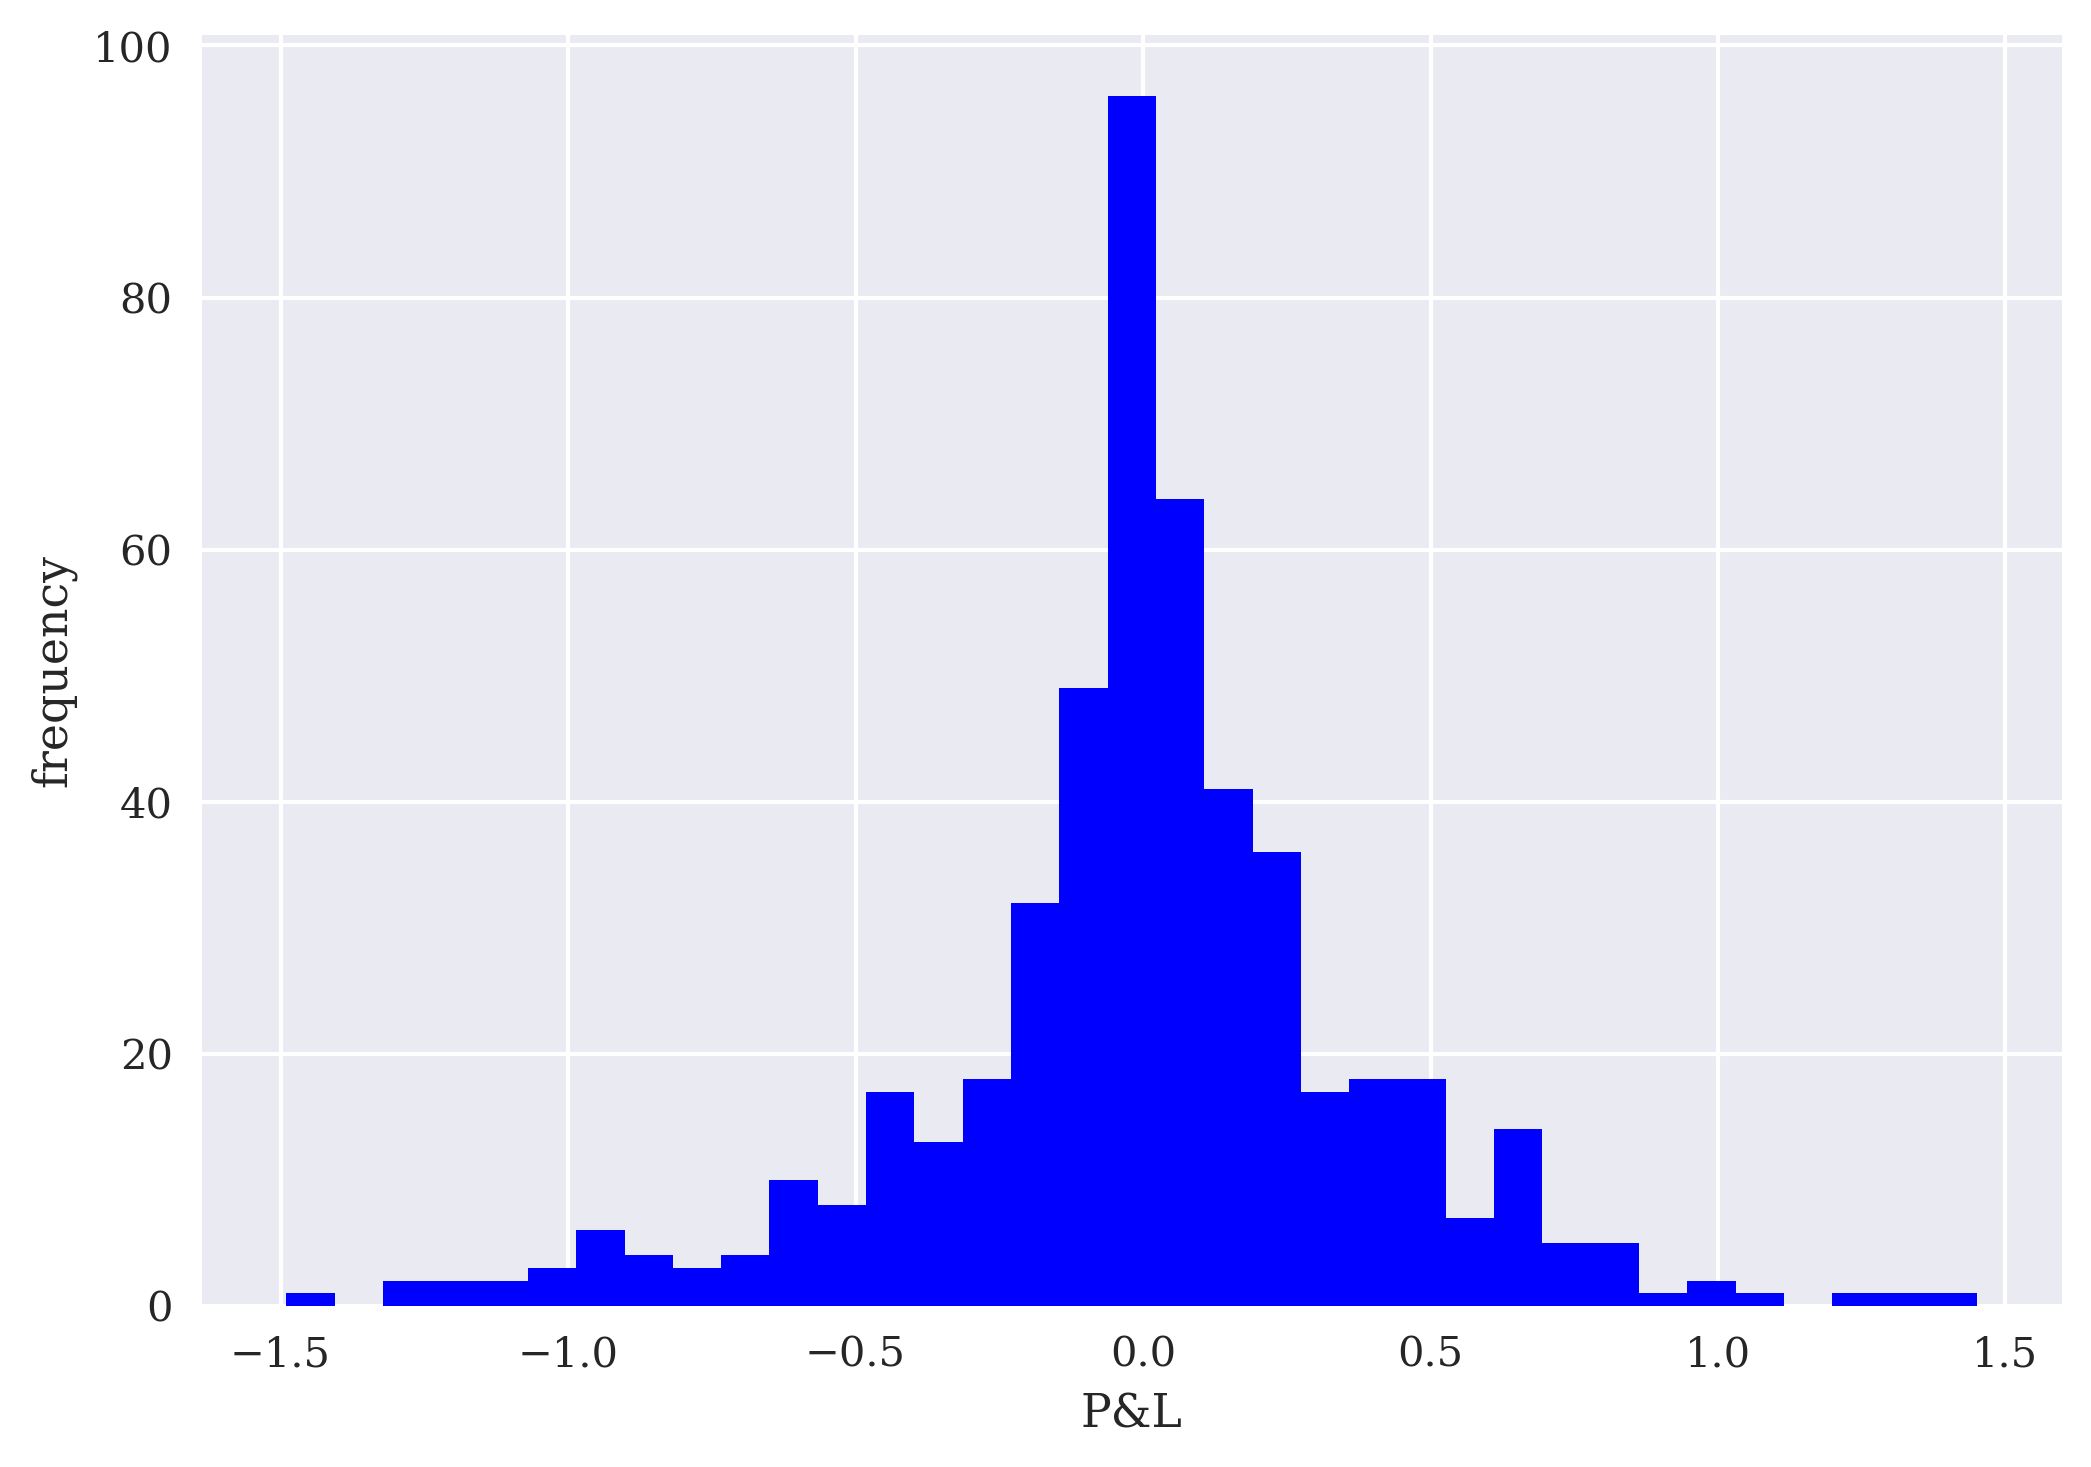

In [36]:
hedging.portfolios['p&l[$]'].hist(bins=35, color='b')
plt.xlabel('P&L')
plt.ylabel('frequency');

In [37]:
from dqlagent_pytorch import *

In [38]:
random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed_all(100)

In [39]:
opt = optim.Adam

In [40]:
class HedgingAgent(DQLAgent):
    pass

In [41]:
from scipy.optimize import minimize

In [42]:
class HedgingAgent(HedgingAgent):
    def opt_action(self, state):
        bnds = [(0, 1)]
        def f_obj(x):
            s = state.copy()
            s[0, 6] = x
            s[0, 7] = ((s[0, 3] - x * s[0, 0]) / s[0, 1])
            s_tensor = torch.FloatTensor(s).to(device)
            with torch.no_grad():
                q_val = self.model(s_tensor)
            return q_val.cpu().numpy()[0, 0]
        try:
            res = minimize(lambda x: -f_obj(x), 0.5, bounds=bnds, method="Powell")
            action = res["x"][0]
        except:
            action = self.env.stock
        return action
    def act(self, state):
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        return self.opt_action(state)

In [43]:
class HedgingAgent(HedgingAgent):
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for state, action, next_state, reward, done in batch:
            target = torch.tensor([reward], dtype=torch.float32).to(device)
            if not done:
                ns = next_state.copy()
                opt_act = self.opt_action(ns)
                ns[0, 6] = opt_act
                ns[0, 7] = ((ns[0, 3] - opt_act * ns[0, 0]) / ns[0, 1])
                ns_tensor = torch.FloatTensor(ns).to(device)
                with torch.no_grad():
                    future_q = self.model(ns_tensor)[0, 0]
                target = target + self.gamma * future_q
            state_tensor = torch.FloatTensor(state).to(device)
            self.optimizer.zero_grad()
            current_q = self.model(state_tensor)[0, 0]
            loss = self.criterion(current_q, target)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [44]:
class HedgingAgent(HedgingAgent):
    def test(self, episodes, verbose=True):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, len(self.env.data) + 1):
                action = self.opt_action(state)
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    templ = f"total penalty={treward:4.2f}"
                    if verbose:
                        print(templ)
                    break

In [45]:
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed_all(100)

In [46]:
hedgingagent = HedgingAgent('SYM', feature=None, n_features=8,
                     env=hedging, hu=128, lr=0.001)

In [47]:
episodes = 10

In [48]:
%time hedgingagent.learn(episodes)

episode=   1 | treward=-60.125 | max=-60.125
episode=   2 | treward=-29.845 | max=-29.845
episode=   3 | treward=-32.590 | max=-29.845
episode=   4 | treward=-77.408 | max=-29.845
episode=   5 | treward=-17.771 | max=-17.771
episode=   6 | treward=-109.463 | max=-17.771
episode=   7 | treward=-14.664 | max=-14.664
episode=   8 | treward=-10.550 | max=-10.550
episode=   9 | treward=-31.113 | max=-10.550
episode=  10 | treward=-43.227 | max=-10.550
CPU times: total: 14 s
Wall time: 20.8 s


In [49]:
hedgingagent.epsilon

0.9752793831785673

In [50]:
%time hedgingagent.test(10)

total penalty=-81.01
total penalty=-255.18
total penalty=-76.36
total penalty=-123.67
total penalty=-207.62
total penalty=-112.01
total penalty=-40.18
total penalty=-45.42
total penalty=-67.23
total penalty=-10.55
CPU times: total: 1min 55s
Wall time: 2min 15s


In [51]:
n = max(hedgingagent.env.portfolios['e'])
n -= 1

In [52]:
hedgingagent.env.portfolios[
    hedgingagent.env.portfolios['e'] == n]['p&l[$]'].describe()

count    503.000000
mean       0.014340
std        0.365680
min       -0.975313
25%       -0.204440
50%        0.012591
75%        0.233028
max        1.145891
Name: p&l[$], dtype: float64

In [53]:
p = hedgingagent.env.portfolios[
    hedgingagent.env.portfolios['e'] == n].iloc[0][
    ['K', 'r', 'sigma']]

In [54]:
title = f"CALL | K={p['K']:.1f} | r={p['r']} | sigma={p['sigma']}"

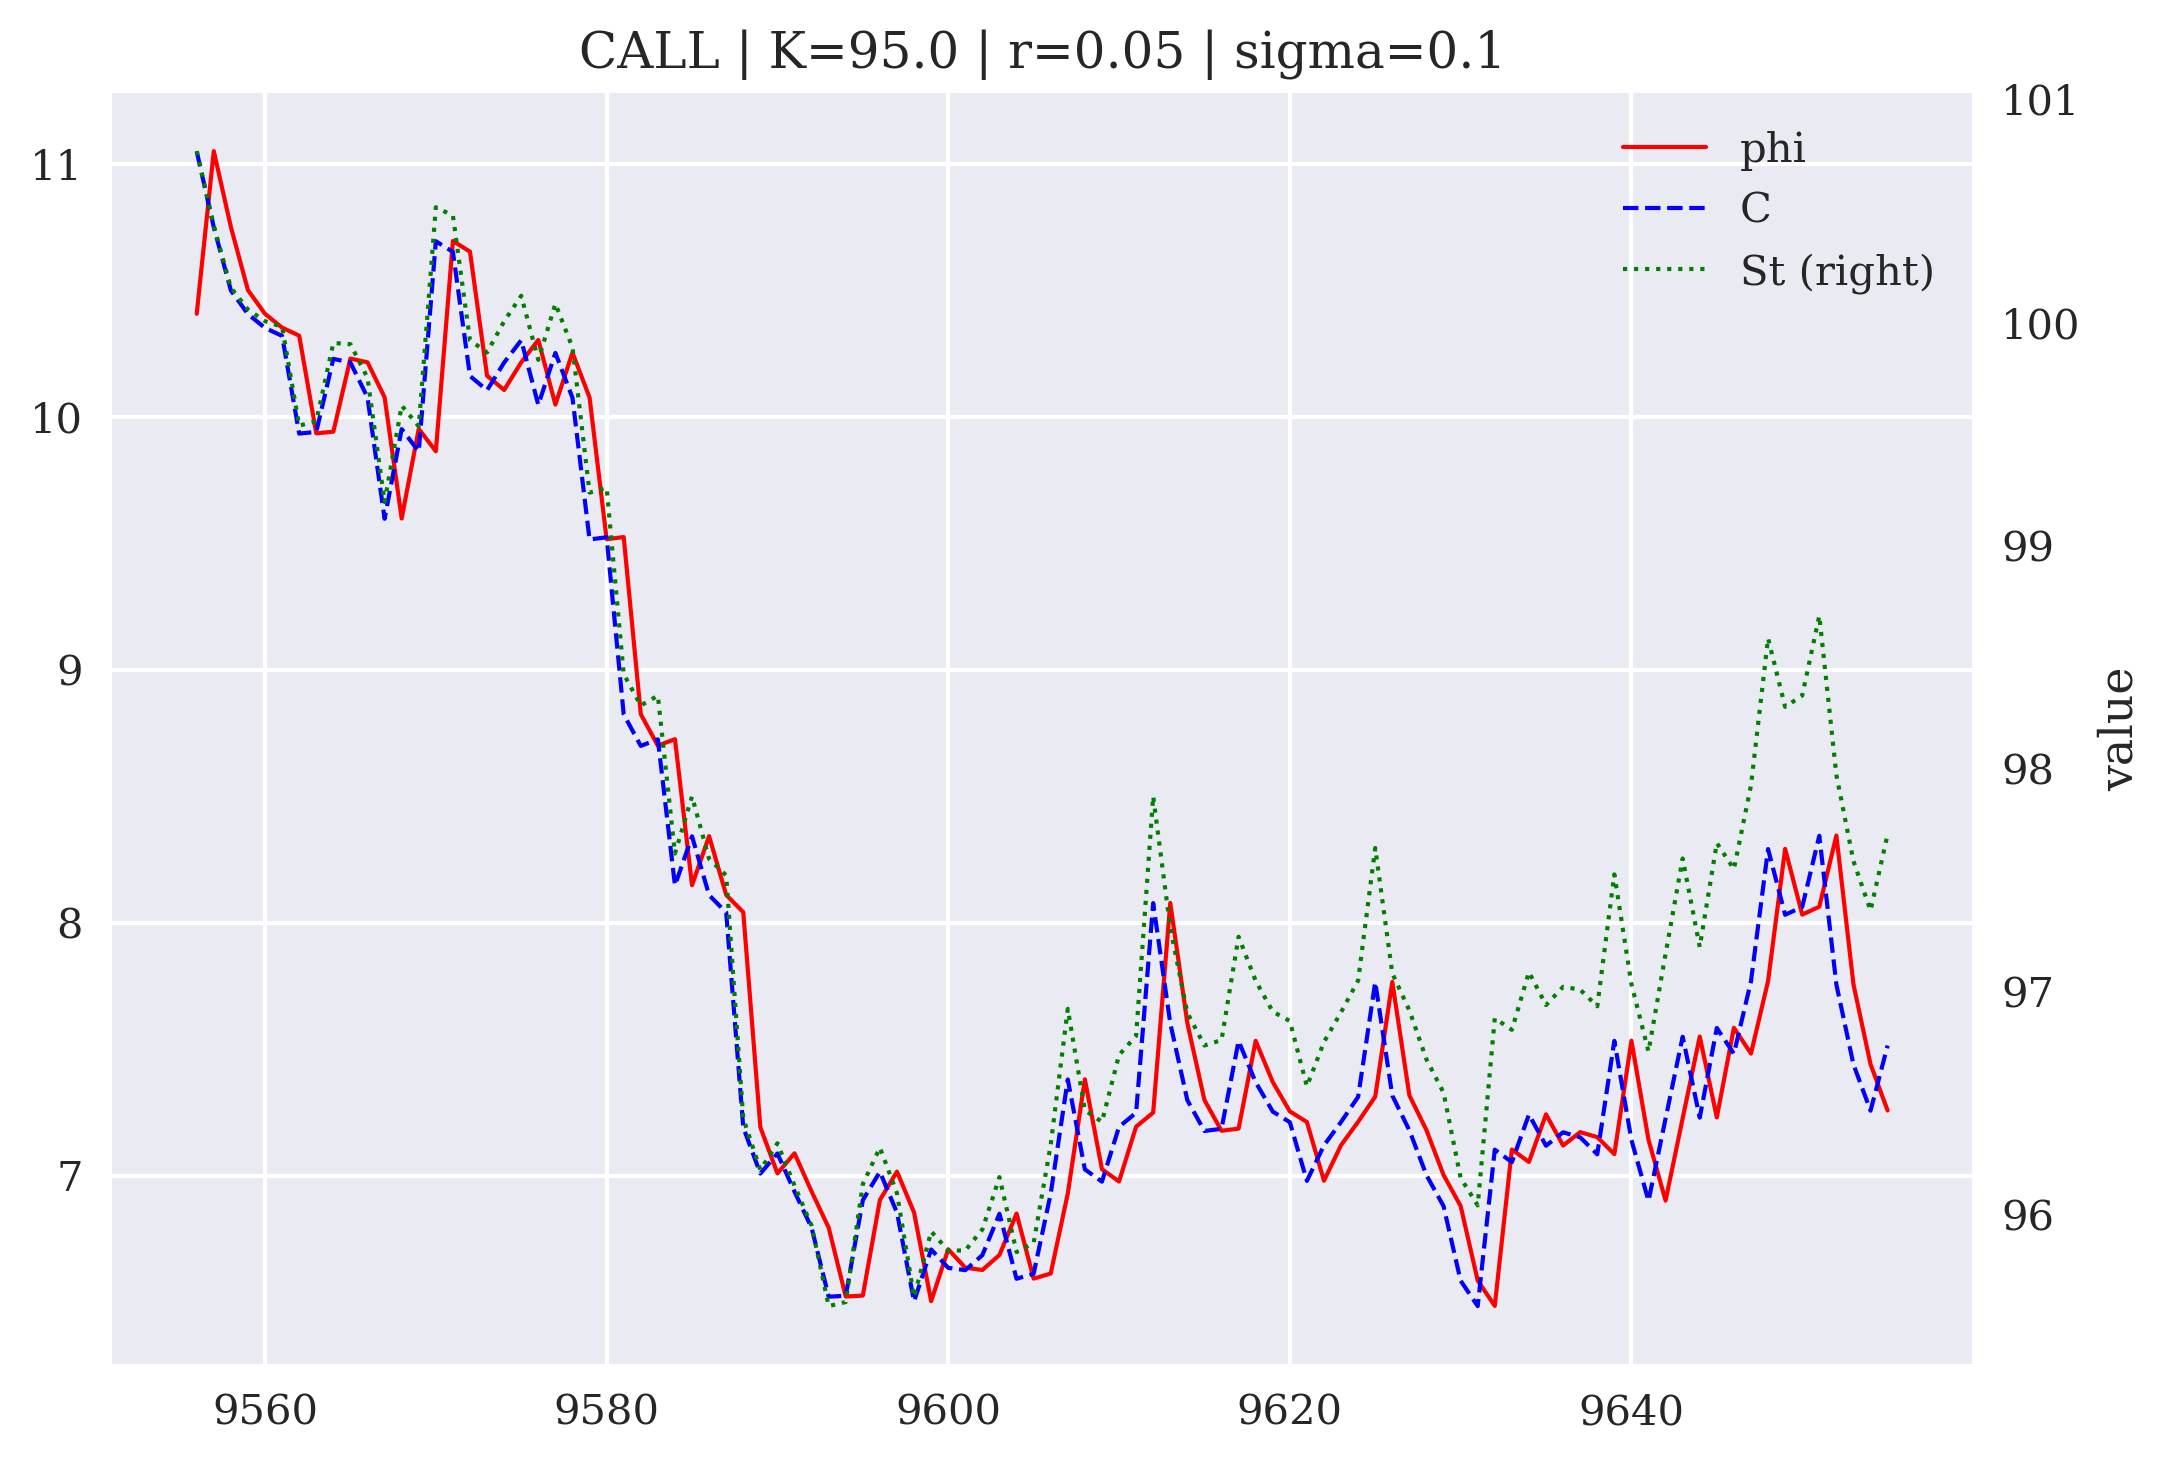

In [55]:
hedgingagent.env.portfolios[
    hedgingagent.env.portfolios['e'] == n][
    ['phi', 'C', 'St']].iloc[:100].plot(
    secondary_y='St', title=title, style=['r-', 'b--', 'g:'], lw=1)
plt.xlabel('time step')
plt.ylabel('value');

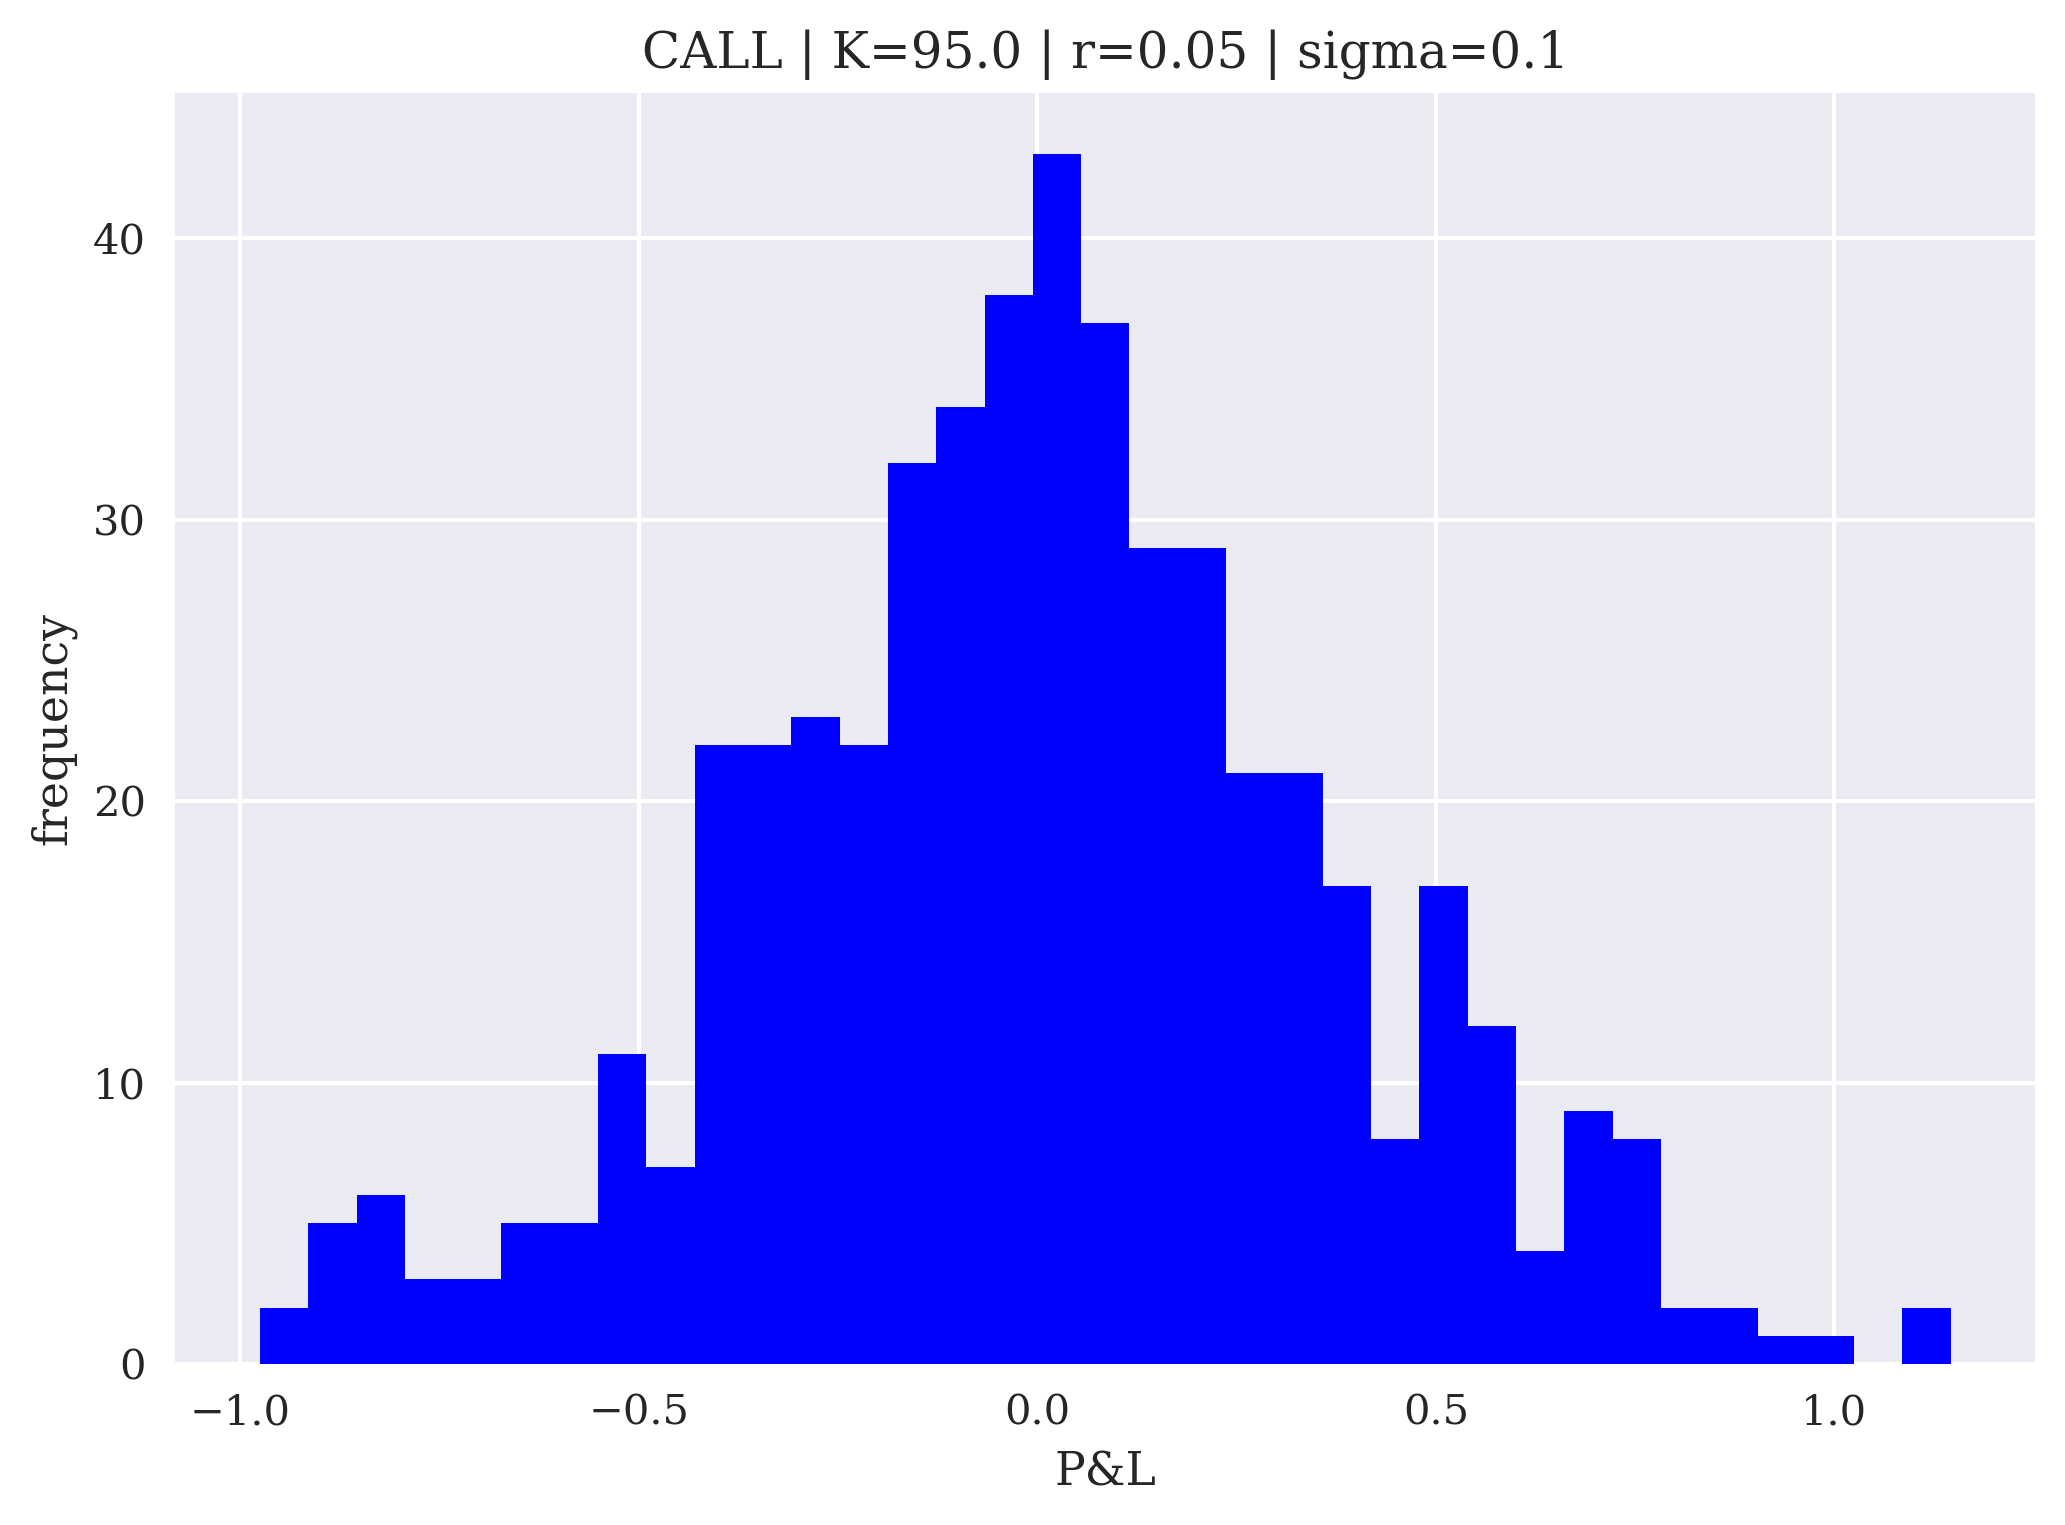

In [56]:
hedgingagent.env.portfolios[
    hedgingagent.env.portfolios['e'] == n]['p&l[$]'].hist(
        bins=35, color='blue')
plt.title(title)
plt.xlabel('P&L')
plt.ylabel('frequency');

## Synthèse et réutilisation (vers rBergomi Deep Hedging)

Les résultats obtenus sur ce prototype DQN servent de base pour un modèle plus riche (rBergomi Deep Hedging). Points d'attention pour la suite : 
- conserver la structure MDP mais remplacer le générateur de trajectoires par un modèle stochastique plus réaliste (vol de volatilité),
- tester la sensibilité aux frictions de marché et aux plages d'ajustement,
- documenter clairement les métriques d'évaluation (PNL distribué, VaR, coût moyen).
